In [30]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

import cv2


import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

from sklearn.preprocessing import StandardScaler
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping

from azureml.core import Workspace, Datastore, Dataset
from azureml.data.datapath import DataPath

# Voor GPU support
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

In [ ]:
experiment_name = 'Facial_Reconstruction'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [ ]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

In [31]:
# Read the data
from PIL import Image

from azureml.core import Workspace, Datastore, Dataset
from azureml.data.datapath import DataPath

# Read and preprocess images

image_size = 100
nr_faces = 1000
X_met_vierkant = []
X_zonder_vierkant = []



# read train_images + vierkantje op afbeelding plaatsen 
path = './Faces/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_faces]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f))
    #im = cv2.imread(os.path.join(path,f),0) # convert to gray 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)

    #Generate random coordinates
    x, y = np.random.randint(0,image_size-25, size=2)

    #vierkantje toevoegen op afbeelding
    data = np.array(im)
    data[x:x+15,y:y+15]=255
    
    #data = (data * 255).astype(np.uint8)#fixt de error van imshow
    X_met_vierkant.append(data)




# read train_images zonder vierkant 
path = './Faces/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_faces]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    #im = (im * 255).astype(np.uint8)#fixt de error van imshow
    X_zonder_vierkant.append(im)
    

#Register for azure database
#X_met_vierkant = X_met_vierkant.register(workspace=ws,name='X_met_vierkant',description='training and test dataset',create_new_version=True)

#X_zonder_vierkant = X_zonder_vierkant.register(workspace=ws,name='X_zonder_vierkant',description='training and test dataset',create_new_version=True)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


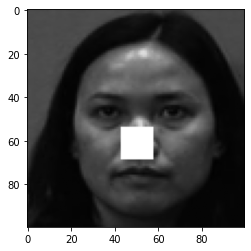

In [32]:
#voorbeeld tonen
img =  X_met_vierkant[2]

plt.imshow(img)




In [33]:
# Training set en test set 
#X_met_vierkant = np.asarray(X_met_vierkant)
#X_met_vierkant = X_met_vierkant /255

# omzeten van list naar array (met vierkant + zonder vierkant in 1 array)
#X_train_noise = np.vstack((np.asarray(X_met_vierkant),np.asarray(X_zonder_vierkant))) # -> vstack -> values

#X_test_noise = np.vstack((np.asarray(X_met_vierkant),np.asarray(X_zonder_vierkant))) # -> vstack -> values


X_train_noise = np.asarray(X_met_vierkant) # -> vstack -> values
X_test_noise = np.asarray(X_met_vierkant) # -> vstack -> values


X_train = np.asarray(X_zonder_vierkant)
X_test = np.asarray(X_zonder_vierkant)

# Image normalization when necessary
# Stap 3 : Randomize training set & test set 
#X_train_noise,X_train = shuffle(X_train_noise,X_train, random_state=0)
#X_test_noise, X_test = shuffle(X_test_noise,X_test, random_state=0)



print(X_train.shape)


(198, 100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


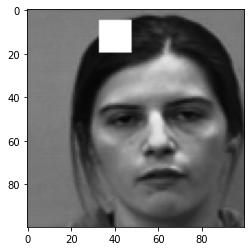

In [34]:
# show 
img =  X_test_noise[3]
#img = np.uint8(img)
plt.imshow(img)

In [35]:
#check of waarden tussen 0 en 1 liggen
print(X_train)

[[[[0.61882353 0.61882353 0.61882353]
   [0.63921569 0.63921569 0.63921569]
   [0.64117647 0.64117647 0.64117647]
   ...
   [0.61960784 0.61960784 0.61960784]
   [0.62470588 0.62470588 0.62470588]
   [0.6145098  0.6145098  0.6145098 ]]

  [[0.64745098 0.64745098 0.64745098]
   [0.66509804 0.66509804 0.66509804]
   [0.66666667 0.66666667 0.66666667]
   ...
   [0.64901961 0.64901961 0.64901961]
   [0.65411765 0.65411765 0.65411765]
   [0.64313725 0.64313725 0.64313725]]

  [[0.64941176 0.64941176 0.64941176]
   [0.6627451  0.6627451  0.6627451 ]
   [0.66078431 0.66078431 0.66078431]
   ...
   [0.65294118 0.65294118 0.65294118]
   [0.66196078 0.66196078 0.66196078]
   [0.64980392 0.64980392 0.64980392]]

  ...

  [[0.46392157 0.46392157 0.46392157]
   [0.47568627 0.47568627 0.47568627]
   [0.47058824 0.47058824 0.47058824]
   ...
   [0.4        0.4        0.4       ]
   [0.38980392 0.38980392 0.38980392]
   [0.38705882 0.38705882 0.38705882]]

  [[0.45568627 0.45568627 0.45568627]
   [0.4

In [36]:
# Image normalization when necessary
# Normalisatie
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#X_train /= 255 #-> moet niet uitgevoerd worden, want de input is al tussen 0 -> 1  
#X_test /= 255


X_train_noise = X_train_noise.astype('float32')
X_test_noise = X_test_noise.astype('float32')

#X_train = np.clip(X_train, 0., 1.)
X_train_noise = np.clip(X_train_noise, 0., 1.) #fix noise error van imshow 255
X_test_noise = np.clip(X_test_noise, 0., 1.) #fix noise error van imshow 255


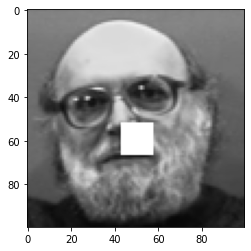

In [37]:
# show 
img =  X_train_noise[5]
#img = np.uint8(img)
plt.imshow(img)

In [ ]:
#Create a directory
import os
script_folder = os.path.join(os.getcwd(), "Facial_reconstruction")
os.makedirs(script_folder, exist_ok=True)

## Denoising convolutional autoencoder


In [ ]:
%%writefile $script_folder/train.py

In [38]:

%%writefile $script_folder/train.py
# Functional model autoencoder
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

import cv2


import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping

from azureml.core import Workspace, Datastore, Dataset
from azureml.data.datapath import DataPath

from azureml.core import Run
import utils

# Model checkpoint
checkpoint_filepath = './Autoencoder_Undercomplete_Faces_bestModel'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)


#parameter
input_dim= X_train.shape[1]
epochs = 5
batchsize = 32
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols,3) # 1 -> grijs waarden, 3 -> kleur

#model trainen

#Encoder
input_img = Input(shape=(image_size, image_size, 3))  ## 1 -> grijs waarden, 3 -> kleur

#dimensie gelijk aan image_size
#x = Flatten()(input_img)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)

# Decoder

x = Conv2D(100, (3, 3), activation='relu', padding='same')(encoder)
x = UpSampling2D((2, 2))(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# get hold of the current run
run = Run.get_context()

Convolution_autoencoder = Model(input_img, decoder)
Convolution_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
Convolution_autoencoder.summary()

X_train_noise = np.reshape(X_train_noise, (len(X_train_noise), image_size, image_size, 3)) 
X_test_noise = np.reshape(X_test_noise, (len(X_test_noise), image_size, image_size, 3)) 
X_test = np.reshape(X_test, (len(X_test), image_size, image_size, 3)) 
X_train = np.reshape(X_train, (len(X_train), image_size, image_size, 3)) 



Convolution_autoencoder.fit(X_train_noise, X_train, epochs=epochs, batch_size=batchsize,shuffle=True )

#run.log('loss', np.float(loss))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
Convolution_autoencoder.save("outputs/model.h5")


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 100, 100, 100)     2800      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 100)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 100)       90100     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 100)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 25, 25, 100)       90100     
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 50, 50, 100)       0   

In [ ]:
import shutil
shutil.copy('utils.py', script_folder)

In [ ]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

# Register environment to re-use later
env.register(workspace = ws)

In [ ]:
from azureml.core import ScriptRunConfig

#args = ['--data-folder', mnist_file_dataset.as_mount(), '--regularization', 0.5]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py',
                      compute_target=compute_target,
                      environment=env)

In [ ]:
run = exp.submit(config=src)
run

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

In [ ]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True) 

In [ ]:
print(run.get_file_names())

In [ ]:
# register model 

cwd = os.getcwd()
print("current", cwd)

model = run.register_model(model_name='Convolution_autoencoder', model_path='model.h5')
print(model.name, model.id, model.version, sep='\t')